<a href="https://colab.research.google.com/github/joaomottin/DataScienceLab/blob/main/GraficoAmazon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files


uploaded = files.upload()


Saving amazon_cells_labelled.txt to amazon_cells_labelled.txt


In [ ]:
import pandas as pd
import io

df = pd.read_csv(io.BytesIO(uploaded['amazon_cells_labelled.txt']),sep = '\t')
print(df)

                                                  text  target
0    So there is no way for me to plug it in here i...       0
1                          Good case, Excellent value.       1
2                               Great for the jawbone.       1
3    Tied to charger for conversations lasting more...       0
4                                    The mic is great.       1
..                                                 ...     ...
995  The screen does get smudged easily because it ...       0
996  What a piece of junk.. I lose more calls on th...       0
997                       Item Does Not Match Picture.       0
998  The only thing that disappoint me is the infra...       0
999  You can not answer calls with the unit, never ...       0

[1000 rows x 2 columns]


In [ ]:
#Mostra a quantidade de linhas e colunas
df.shape

(1000, 2)

In [ ]:
#Usar somente se o target não estiver transformado em 0 ou 1
df['target'] = df['target'].apply(lambda x: 0 if x == 'ham' else 1)

In [ ]:
df.groupby('target')['target'].count()

,target
target,
0,500
1,500


In [ ]:
#Faz a contagem dos dados
contagem_classes = df.groupby('target')['target'].count()
total = contagem_classes.sum()

#Depois multiplica por 100 para dar em %
porcentagem_classes = contagem_classes / total * 100
print(porcentagem_classes)


target
0    50.0
1    50.0
Name: target, dtype: float64


In [ ]:
#Separamos os dados para treino e test
import numpy as np
from sklearn.model_selection import train_test_split
X = df['text']
y= df['target']
#Embaralhamos os dados sendo 25% para teste e 75% para treino
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
#!pip install scikit-learn==1.2.2
from sklearn.feature_extraction.text import TfidfVectorizer

#Baixa uma lista de palavras que não tem peso para frases
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords


#Pega as palavras sem peso da lingua "Ingles"
stop_words = stopwords.words('english')

#Armazena o indice das frases que foram para teste e treino mesmo apos embaralhar
X_train_indices = X_train.index
X_test_indices = X_test.index

#Usamos os indices que foram armazenos para pegar exatamente as frases separadas de treino e teste
X_train_text = df['text'].iloc[X_train_indices]
X_test_text = df['text'].iloc[X_test_indices]


vectorizer = TfidfVectorizer(stop_words=stop_words)
# Faz a contagem de palavras das frases
X_train_tfidf = vectorizer.fit_transform(X_train_text)
# Faz um teste com as contagem de palavras obtidas no treino e não considera palavras novas
X_test_tfidf = vectorizer.transform(X_test_text)




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
model = RandomForestClassifier()
#Faz o modelo aprender usando os dados convertidos
model.fit(X_train_tfidf, y_train)

RandomForestClassifier()

In [ ]:
#Faz uma previsão com os dados obtidos no teste informando (0 ou 1)
y_pred = model.predict(X_test_tfidf)

In [ ]:
#Nos mostra a confiança do modelo, a % que ele acha que um item é positivo
y_pred_proba = model.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
from sklearn.linear_model import LogisticRegression

lr_model = LogisticRegression(max_iter=1000, random_state=42)

lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)
y_pred_proba_lr = lr_model.predict_proba(X_test_tfidf)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.772
Precision: 0.8
Recall: 0.7441860465116279


In [ ]:
#Pega as probabilidades de ser positivo e de ser negativo
probs = model.predict_proba(X_test_tfidf)
#Muda para pegar somente a probabilidade de ser positivo
positive_probs = probs[:,1]

#Mostra a lista das probabilidades de ser positivo
print(positive_probs)

[0.74       0.73       0.7        0.1        0.54       0.88
 0.29       0.87       0.05       0.96       1.         0.01
 0.05       0.47       0.42       0.28       0.83       0.01
 0.32       0.92       0.65166667 0.89       0.84       0.15
 0.3        0.085      0.03       0.35       0.36       0.88
 0.165      0.205      0.01       0.81       0.175      0.15
 0.74       0.54       0.53       0.01       0.205      0.675
 0.16       0.62       0.53       0.9        0.95       0.07
 0.18       0.3        0.41       0.21       0.36       0.22
 0.18       0.77       0.37       0.9        0.43       0.05
 0.97       0.77       0.25       0.025      0.02       0.89
 0.89       0.92       0.05       0.09       0.88       0.3
 0.06       0.8        0.91       0.97       0.04       0.225
 0.36       0.34       0.74       0.02       0.98       0.61
 0.2        0.17       0.07       0.29       0.92       0.51
 0.245      0.96       0.06       0.26       0.66       0.06
 0.04       0.94       

In [ ]:
#Organiza todas as probabilidades de ser positivo junto do target
df_pos = pd.DataFrame({"prob_spam": positive_probs,"target":y_test})

In [ ]:
df_pos

,prob_spam,target
521,0.740,1
737,0.730,1
740,0.700,1
660,0.100,0
411,0.540,1
...,...,...
109,0.170,0
430,0.190,1
77,0.970,1
84,0.810,0


In [ ]:
#Mostra as linhas e colunas
df_pos.shape

(250, 2)

In [ ]:
#Separa apenas para os que são positivos
df_apenas_positivo = df_pos.loc[df_pos['target']==1]

In [ ]:
#Mostra as linhas e colunas
df_apenas_positivo.shape

(129, 2)

In [ ]:
df_apenas_positivo

,prob_spam,target
521,0.74,1
737,0.73,1
740,0.70,1
411,0.54,1
678,0.88,1
...,...,...
333,0.41,1
514,0.92,1
306,0.98,1
430,0.19,1


In [ ]:
df_pos

,prob_spam,target
521,0.740,1
737,0.730,1
740,0.700,1
660,0.100,0
411,0.540,1
...,...,...
109,0.170,0
430,0.190,1
77,0.970,1
84,0.810,0


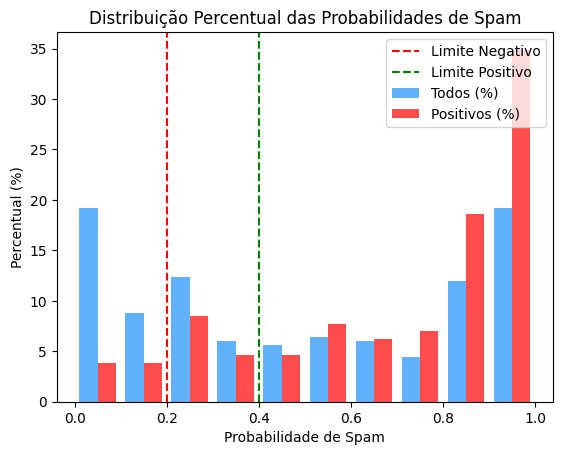

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

#Cria as caixas (bins) de 10% em 10% porcento
step = 0.1
bins = np.arange(0, 1 + step, step)

#Faz a contagem de todas as probabilidades
hist_all, _ = np.histogram(df_pos["prob_spam"], bins=bins)
#Faz a contagem somente das probabilidades que realmente eram positivas
hist_pos, _ = np.histogram(df_apenas_positivo["prob_spam"], bins=bins)

# Convertendo para percentual (%)
hist_all_pct = (hist_all / hist_all.sum()) * 100
hist_pos_pct = (hist_pos / hist_pos.sum()) * 100

# Posicionamento das barras
width = step * 0.4
x = bins[:-1] + step/2

plt.bar(x - width/2, hist_all_pct, width=width, label='Todos (%)', color='#1E90FF', alpha=0.7)
plt.bar(x + width/2, hist_pos_pct, width=width, label='Positivos (%)', color='red', alpha=0.7)

plt.xlabel('Probabilidade de Spam')
plt.ylabel('Percentual (%)')
plt.title('Distribuição Percentual das Probabilidades de Spam')

# Pontos de corte customizáveis
threshold_neg = 0.2
threshold_pos = 0.4
plt.axvline(threshold_neg, color='red', linestyle='--', label='Limite Negativo')
plt.axvline(threshold_pos, color='green', linestyle='--', label='Limite Positivo')

plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Corte 0.2 -> considera como positivo apenas prob > 0.2 (zona negativa como 0)
y_pred_02 = (df_pos["prob_spam"] > 0.2).astype(int)

# Corte 0.4 -> considera como positivo prob >= 0.4 (zona positiva como 1)
y_pred_04 = (df_pos["prob_spam"] >= 0.4).astype(int)

# métricas para corte 0.2
print("Corte 0.2")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_02))
print("Precision:", precision_score(df_pos["target"], y_pred_02))
print("Recall:", recall_score(df_pos["target"], y_pred_02))
print("F1:", f1_score(df_pos["target"], y_pred_02))

# métricas para corte 0.4
print("\nCorte 0.4")
print("Accuracy:", accuracy_score(df_pos["target"], y_pred_04))
print("Precision:", precision_score(df_pos["target"], y_pred_04))
print("Recall:", recall_score(df_pos["target"], y_pred_04))
print("F1:", f1_score(df_pos["target"], y_pred_04))


Corte 0.2
Accuracy: 0.724
Precision: 0.6685393258426966
Recall: 0.9224806201550387
F1: 0.7752442996742671

Corte 0.4
Accuracy: 0.764
Precision: 0.7611940298507462
Recall: 0.7906976744186046
F1: 0.7756653992395437


In [ ]:
def assign_zone(prob):
    if prob <= 0.2:
        return "negativa"
    elif prob >= 0.4:
        return "positiva"
    else:
        return "manual"

#Usa a função para cada uma das probabilidades
df_pos["zone"] = df_pos["prob_spam"].apply(assign_zone)

# Ver quantos exemplos vão para cada zona
print(df_pos["zone"].value_counts())


zone
positiva    134
negativa     72
manual       44
Name: count, dtype: int64


array([[<Axes: title={'center': 'prob_spam'}>,
        <Axes: title={'center': 'target'}>]], dtype=object)

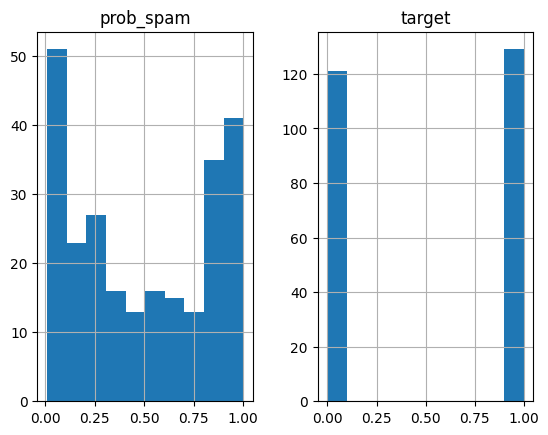

In [ ]:
df_pos.hist()

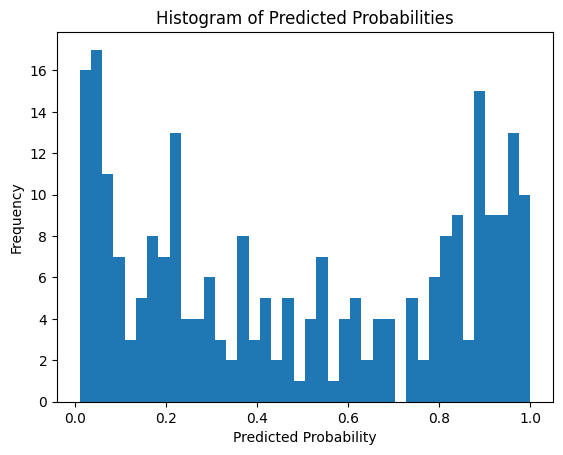

In [ ]:
plt.hist(positive_probs, bins=40)
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.title("Histogram of Predicted Probabilities")
plt.show()

In [ ]:
nomes_features = vectorizer.get_feature_names_out()

          Palavra  Importancia
593         great     0.073453
587          good     0.029290
1439        works     0.024909
1408         well     0.021316
943         phone     0.021116
459     excellent     0.017182
768          love     0.016900
858          nice     0.015432
131          best     0.014836
254   comfortable     0.011851


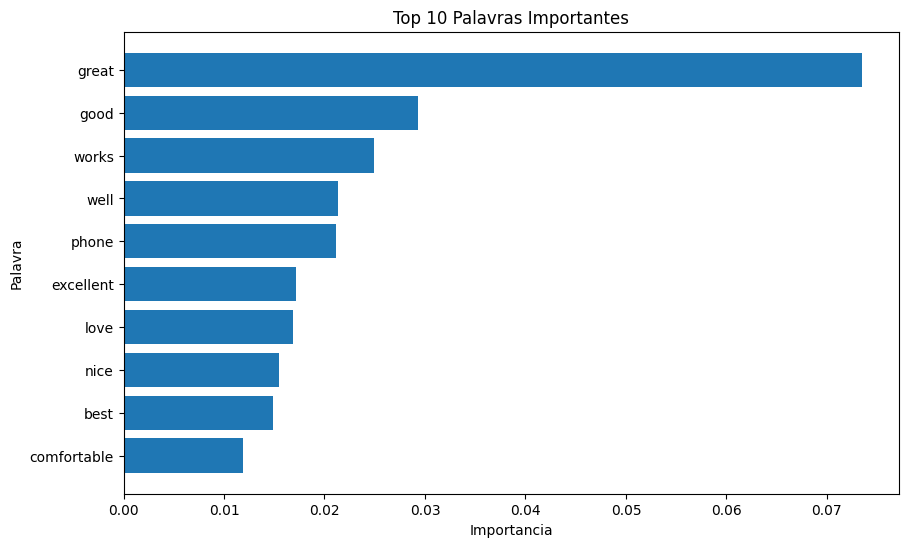

In [ ]:
#Pega a importancia de cada palavra consideradas importantes que o modelo selecionou
importances = model.feature_importances_

#Pega a lista de palavras na mesma ordem das importancias
feature_names = vectorizer.get_feature_names_out()
#Cria um dataframe com as palavras consideradas importantes e suas notas
feature_importance_df = pd.DataFrame({'Palavra': feature_names, 'Importancia': importances})

#Ordena a tabela pela coluna Importancia
feature_importance_df = feature_importance_df.sort_values('Importancia', ascending=False)

#Quantidade de palavras que queremos
N = 10
print(feature_importance_df.head(N))

#Desenha o mapa
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Palavra'][:N], feature_importance_df['Importancia'][:N])
plt.xlabel('Importancia')
plt.ylabel('Palavra')
plt.title('Top {} Palavras Importantes'.format(N))
plt.gca().invert_yaxis()
plt.show()


--- Avaliação de Performance dos Modelos ---

Random Forest:
Acurácia: 0.7720
Precisão: 0.8000
Recall: 0.7442
F1-Score: 0.7711
AUC-ROC: 0.8507
AUC-PR (AP): 0.8558

Regressão Logística:
Acurácia: 0.8040
Precisão: 0.8279
Recall: 0.7829
F1-Score: 0.8048
AUC-ROC: 0.8948
AUC-PR (AP): 0.8800


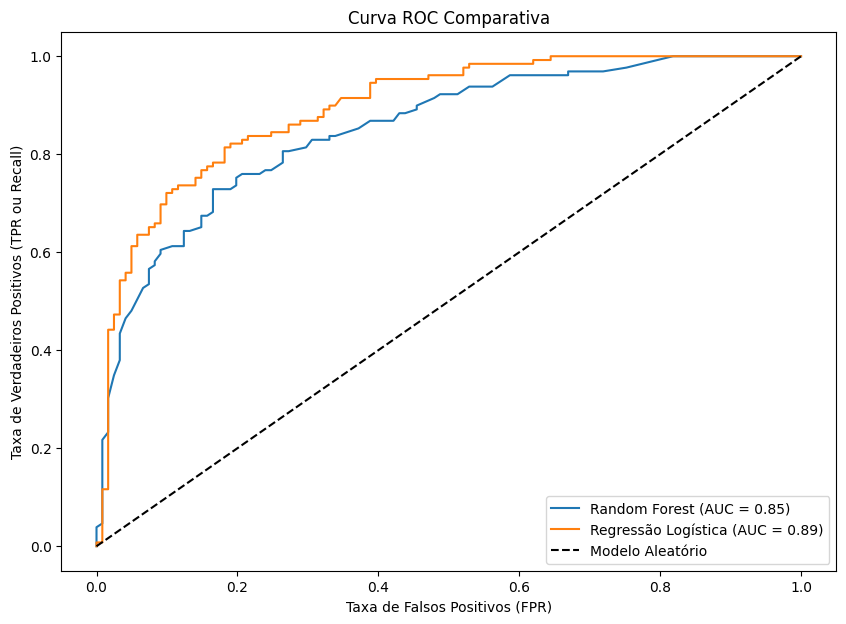

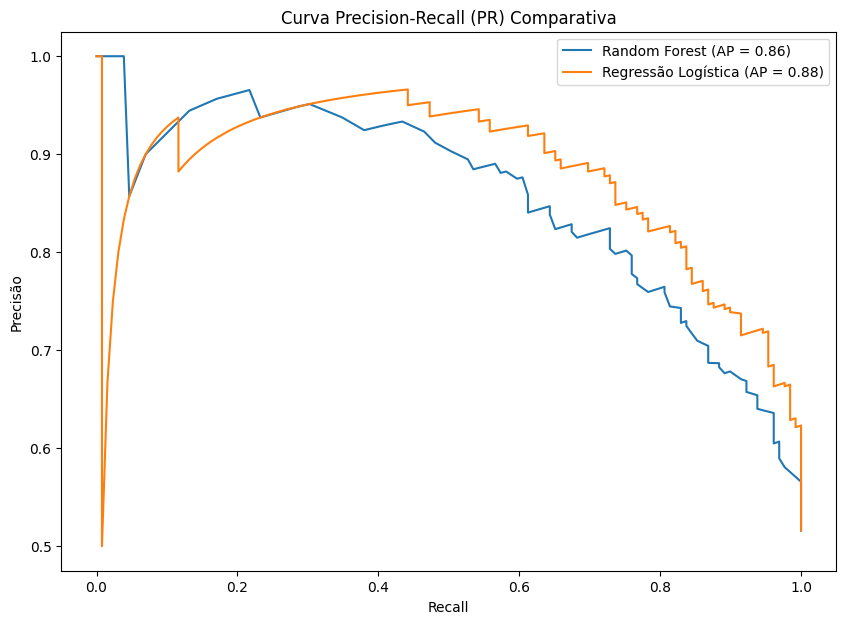

In [ ]:
# --- INÍCIO DO NOVO CÓDIGO ---

# 1. IMPORTAÇÕES NECESSÁRIAS
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, average_precision_score,
                             roc_curve, precision_recall_curve)
import matplotlib.pyplot as plt

# 2. CALCULAR AS MÉTRICAS PARA AMBOS OS MODELOS

# Lembre-se que já temos as previsões:
# RandomForest: y_pred, y_pred_proba
# Logistic Regression: y_pred_lr, y_pred_proba_lr

print("\n--- Avaliação de Performance dos Modelos ---")

# Métricas para o RandomForest
print("\nRandom Forest:")
rf_accuracy = accuracy_score(y_test, y_pred)
rf_precision = precision_score(y_test, y_pred)
rf_recall = recall_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_auc_roc = roc_auc_score(y_test, y_pred_proba)
rf_auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Acurácia: {rf_accuracy:.4f}")
print(f"Precisão: {rf_precision:.4f}")
print(f"Recall: {rf_recall:.4f}")
print(f"F1-Score: {rf_f1:.4f}")
print(f"AUC-ROC: {rf_auc_roc:.4f}")
print(f"AUC-PR (AP): {rf_auc_pr:.4f}")

# Métricas para a Regressão Logística
print("\nRegressão Logística:")
lr_accuracy = accuracy_score(y_test, y_pred_lr)
lr_precision = precision_score(y_test, y_pred_lr)
lr_recall = recall_score(y_test, y_pred_lr)
lr_f1 = f1_score(y_test, y_pred_lr)
lr_auc_roc = roc_auc_score(y_test, y_pred_proba_lr)
lr_auc_pr = average_precision_score(y_test, y_pred_proba_lr)

print(f"Acurácia: {lr_accuracy:.4f}")
print(f"Precisão: {lr_precision:.4f}")
print(f"Recall: {lr_recall:.4f}")
print(f"F1-Score: {lr_f1:.4f}")
print(f"AUC-ROC: {lr_auc_roc:.4f}")
print(f"AUC-PR (AP): {lr_auc_pr:.4f}")

# 3. PLOTAR AS CURVAS DE COMPARAÇÃO

# Curva ROC
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_proba)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {rf_auc_roc:.2f})')
plt.plot(fpr_lr, tpr_lr, label=f'Regressão Logística (AUC = {lr_auc_roc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Modelo Aleatório') # Linha de referência
plt.xlabel('Taxa de Falsos Positivos (FPR)')
plt.ylabel('Taxa de Verdadeiros Positivos (TPR ou Recall)')
plt.title('Curva ROC Comparativa')
plt.legend()
plt.show()

# Curva PR (Precision-Recall)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba)
precision_lr, recall_lr, _ = precision_recall_curve(y_test, y_pred_proba_lr)

plt.figure(figsize=(10, 7))
plt.plot(recall_rf, precision_rf, label=f'Random Forest (AP = {rf_auc_pr:.2f})')
plt.plot(recall_lr, precision_lr, label=f'Regressão Logística (AP = {lr_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precisão')
plt.title('Curva Precision-Recall (PR) Comparativa')
plt.legend()
plt.show()

# --- FIM DO NOVO CÓDIGO ---